# RNA Structure Functions

## Function Definition

### Import Required Packages

In [1]:
# built-in packages
import ast
import os
from pathlib import Path
import re
import sys

# third-party packages
import Bio.SeqIO
from IPython.display import SVG
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# the Vienna RNA python package is automatically installed in a particular directory
# ensure that that directory is on Python's path
VIENNA_DIR = '/usr/local/lib/python3.7/site-packages'
sys.path.append(VIENNA_DIR)
import RNA

### Basic Utility Functions

In [2]:
def _fold_compound(seq):
    """
    Internal helper function that prepares a fold_compound for the provided sequence
    """
    return RNA.fold_compound(seq)


def _mfe(seq):
    """
    Internal helper function that creates a fold_compound and runs the mfe() method
    """
    fc = _fold_compound(seq)
    return fc.mfe()


def mfe(seq):
    """
    Computes the minimum free energy of folding for the provided sequence in kcal/mol
    """
    _, mfe = _mfe(seq)
    return mfe


def secondary_structure(seq):
    """
    Computes the secondary structure with the minimum free energy for the provided sequence,
    in dot-bracket notation
    """
    sec_struct, _ = _mfe(seq)
    return sec_struct


def _pair_table(seq):
    """
    Internal helper that computes the pair table representation of the secondary structure
    """
    sec_struct = secondary_structure(seq)
    # the pair table is a tuple, and has an extra element at the front (the length of seq)
    return list(RNA.ptable(sec_struct))[1:]


def base_pairs(seq):
    """
    Computes the base pairs in the MFE for the provided sequence, returning them as 2-tuples
    The first index of the tuple is always smaller than the second
    """
    pair_table = _pair_table(seq)
    bps = []
    for i, paired_base in enumerate(pair_table):
        curr_base = i+1
        if curr_base < paired_base:
            bps.append((curr_base, paired_base))
    return bps

In [3]:
def _loop_structure_df(seq):
    """
    Internal helper that, given a sequence, computes the MFE structure and the energy/structure at the
    loop level; helps provided both structural type and base energy information in DataFrame form
    """
    
    # create a fold_compound object and compute the MFE secondary structure in dot-bracket form
    fc = _fold_compound(seq)
    ss, _ = fc.mfe() 

    # use a verbose method that writes individual loop energies/locations to a file
    temp_file = Path('loop_energies.txt')
    with open(temp_file, 'w', encoding='utf-8') as fwrite:
        fc.eval_structure_verbose(ss, fwrite)
        
    # instantiate a DataFrame to store the loop structure information
    # bp2 can be None/NaN for a hairpin loop, both bp columns are None for an external loop
    loop_structure_df = pd.DataFrame(columns=['loop_type', 'bp1', 'bp2', 'energy'])
    
    # read the file just created by eval_structure_verbose()
    with open(temp_file, 'r') as fread:
        
        # we're assuming only one loop of type external; instantiate a counter to keep track
        external_counter = 0
        
        for i, line in enumerate(fread):

            loop_type = re.compile(r'^([A-z]+)\s+loop').search(line).group(1).lower()
            # for some reason, this function returns loop energies in dcal/mol; convert to kcal/mol
            loop_energy = int(re.findall(r'-?[0-9]+$', line)[0])/100
            
            base_pairs_regex = re.findall(r'\(\s*[0-9]+,\s*[0-9]+\)', line)

            if loop_type == "interior":

                # we will have two tuples with the base pairs defining the loop
                bp1, bp2 = [ast.literal_eval(bp_tup) for bp_tup in base_pairs_regex]

            elif loop_type in ['hairpin', 'multi']:
                # just one tuple for the base pair that defines a hairpin or multi loop
                bp1 = ast.literal_eval(base_pairs_regex[0])
                bp2 = None

            # currently assuming just one of these
            elif loop_type == 'external':
                if external_counter == 0:
                    external_counter = 1
                    bp1 = bp2 = None
                else:
                    raise ValueError('Multiple external loops encountered.')

            loop_structure_df.loc[i, :] = [loop_type, bp1, bp2, loop_energy]

    # remove the temporary file we had to create to get this information
    temp_file.unlink()
    
    return loop_structure_df


def _bps_from_loop_df(loop_structure_df):
    """
    Internal helper that computes all of the base pairs for a given sequence from the return value 
    of the _loop_structure_df helper
    """
    # identify all base pairs, this will help us define the multi loops, if any
    bps = []
    for bp_col in ['bp1', 'bp2']:
        bps += list(loop_structure_df[bp_col][loop_structure_df[bp_col].notna()])
    bps.sort()
    return bps


def _multi_bases(multi_bp, all_bps, include_bp=False):
    """
    Internal helper that computes all bases involved in a multi-branch loop
    Can either include or exclude the base pairs themselves that define the loop
    """
    multi_bases = []
    multi_bps = []
    
    if include_bp:
        multi_bps += multi_bp

    multi_start, multi_end = multi_bp
    curr_base = multi_start+1

    while curr_base < multi_end:
        downstream_bps = [bp for bp in all_bps if bp[0] >= curr_base]
        if downstream_bps:

            next_bp = downstream_bps[0]
            if include_bp:
                multi_bps += next_bp

            if next_bp[0] > multi_end:
                multi_bases += list(range(curr_base, multi_end))
                curr_base = multi_end
            else:
                multi_bases += list(range(curr_base, next_bp[0]))
                curr_base = next_bp[1]+1
        else:
            multi_bases += list(range(curr_base, multi_end))
            curr_base = multi_end
            
    return multi_bases + multi_bps
    

def structure_types(seq):
    """
    Identifies the type of secondary structure each base is involved in:
    - options are: base_pair, interior, hairpin, or unstructured (i.e. external)
    """
    
    # use a helper function to create and parse a loop-specific structure file
    loop_structure_df = _loop_structure_df(seq)
    
    # instantiate dict for each secondary structure type (will handle unstructured later)
    structure_types = ['base_pair', 'interior', 'hairpin', 'multi']
    structure_dict = {structure_type: [] for structure_type in structure_types}
    
    # get base pairs in tuple format, needed for multi branch assessment
    bps = _bps_from_loop_df(loop_structure_df)
    for bp in bps:
        structure_dict['base_pair'] += bp
    
    for row in loop_structure_df.itertuples(index=False):
        if row.loop_type == 'interior':
            interior = list(range(row.bp1[0]+1, row.bp2[0])) + list(range(row.bp2[1]+1, row.bp1[1]))
            structure_dict['interior'] += interior
        
        elif row.loop_type == 'hairpin':
            hairpin = list(range(row.bp1[0]+1, row.bp1[1]))
            structure_dict['hairpin'] += hairpin
        
        elif row.loop_type == 'multi':
            structure_dict['multi'] += _multi_bases(row.bp1, bps)
            
    # calculate the unstructured base pairs; these won't be in any of our above lists
    # NOTE: structured_bases (and the lists from which it's made) is 1-INDEXED
    structured = []
    for base_list in structure_dict.values():
        structured += base_list
    structure_dict['unstructured'] = list(set(range(1, len(seq)+1)).difference(set(structured)))
    
    # populate an array of structure type labels indexed to the original sequence
    structure_types = np.empty(len(seq), dtype=np.dtype('U20'))
    for struct_type, bases in structure_dict.items():
        if bases:
            structure_types[np.array(bases)-1] = struct_type
        
    return list(structure_types)


def base_energies(seq):
    """
    Calculates the folding energy associated with each base in the given sequence; for bases
    involved in base pairs, and thus defining the border between loops in the MFE structure for
    the sequence, the average of the two adjacent loops is reported
    """
    
    # use a helper function to create and parse a loop-specific structure file
    loop_structure_df = _loop_structure_df(seq)
    
    base_dict = {i: [] for i in range(1, len(seq)+1)}
    
    # get base pairs in tuple format, needed for multi branch assessment
    bps = _bps_from_loop_df(loop_structure_df)
    
    for row in loop_structure_df.itertuples(index=False):

        bases_in_loop = []
        
        if row.loop_type == 'interior':
            interior = tuple(range(row.bp1[0]+1, row.bp2[0])) + tuple(range(row.bp2[1]+1, row.bp1[1]))
            bases_in_loop = row.bp1 + row.bp2 + interior
        elif row.loop_type == 'hairpin':
            hairpin = tuple(range(row.bp1[0]+1, row.bp1[1]))
            bases_in_loop = row.bp1 + hairpin
        elif row.loop_type == 'multi':
            bases_in_loop = _multi_bases(row.bp1, bps, include_bp=True)
        # internal helper that we use is already controlling that there's only one external loop 
        elif row.loop_type == 'external':
            external_energy = row.energy
        
        for base in bases_in_loop:
            base_dict[base] += [row.energy]

    # slip in the unstructured/external energy to all bases that don't already have an entry
    for base, energies in base_dict.items():
        if not energies:
            base_dict[base] += [external_energy]
            
    # average all bases that have multiple energies
    base_energies = np.empty(len(seq))
    for base, energies in base_dict.items():
        base_energies[base-1] = np.around(np.array(energies).mean(), decimals=2)
    
    return list(base_energies)


def energy_plot(seq):
    """
    Plot the base energies and structure types for the MFE structure of a given sequence
    """

    energies = base_energies(seq)
    structures = structure_types(seq)

    color_dict = {
        'unstructured': 'gray',
        'base_pair': 'blue',
        'hairpin': 'green',
        'interior': 'red',
        'multi': 'orange'
    }

    _, ax = plt.subplots()
    plt.bar(
        list(range(1, len(seq)+1)),
        energies,
        width=0.4,
        color=[color_dict[structure] for structure in structures]
    )
    plt.xlabel('Sequence Position (base)', fontsize=16)
    plt.ylabel('Base energy (kcal/mol)', fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    ax.axhline(linestyle='--', linewidth=0.5, color='k')

    legend_elems = [Patch(edgecolor=c, facecolor=c, label=l) for l, c in color_dict.items()]
    ax.legend(handles=legend_elems, loc='center left', fontsize=13, bbox_to_anchor=(1, 0.5))

    plt.show()
    

def mfe_summary(seq):
    """
    Print out a dashboard showing the MFE secondary structure and its per-base energies
    """
    
    # make the base energy plot
    energy_plot(seq)
    
    # compute minimum free energy (MFE) and corresponding structure
    fc = RNA.fold_compound(seq)
    (ss, mfe) = fc.mfe()
    
    # plot the MFE structure (requires saving to temporary file)
    temp_file = Path('mfe_plot.svg')
    RNA.svg_rna_plot(seq, ss, str(temp_file))
    return SVG(filename=temp_file)

## Example Usage

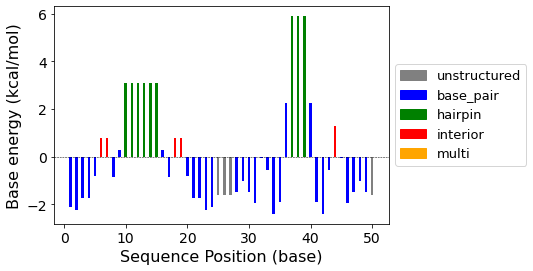

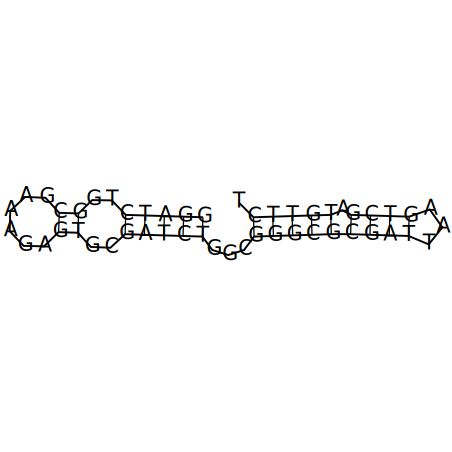

In [4]:
pgi = str(Bio.SeqIO.read('pgi.fasta', 'fasta').seq)

mfe_summary(pgi[:50])